In [1]:
# Define the libraries and imports
# Panda
import pandas as pd
#mat plot
import matplotlib.pyplot as plt
#Sea born
import seaborn as sns
#Num py
import numpy as np
#Sk learn imports
from sklearn import tree,preprocessing
#ensembles
from sklearn.ensemble import RandomForestClassifier  # ,BaggingClassifier
import sklearn.metrics as metrics
#scores
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,roc_auc_score,auc  
#models
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_val_score,learning_curve,GridSearchCV,validation_curve
from sklearn.linear_model import LogisticRegressionCV
# from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
#export the model
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data from the path to the dataSet
def load_dataset(dataSet_path):
    data = pd.read_csv(dataSet_path, encoding="ISO-8859-1")
#     data = pd.read_csv("data.csv", encoding="ISO-8859-1")
    return data


In [3]:
#Imputation
def impute_data(df):
    df.dropna(inplace=True)

In [4]:
# Coversion weight to int
def weight_to_int(df):
    df['Weight'] = df['Weight'].str[:-3]
    df['Weight'] = df['Weight'].apply(lambda x: int(x))
    return df

In [5]:
# Coversion height to int
def height_convert(df_height):
        try:
            feet = int(df_height[0])
            dlm = df_height[-2]
            if dlm == "'":
                height = round((feet * 12 + int(df_height[-1])) * 2.54, 0)
            elif dlm != "'":
                height = round((feet * 12 + int(df_height[-2:])) * 2.54, 0)
        except ValueError:
            height = 0
        return height

In [6]:
def height_to_int(df):
    df['Height'] = df['Height'].apply(height_convert)

In [7]:
#One Hot Encoding of a feature
def one_hot_encoding(df,column):
    encoder = preprocessing.LabelEncoder()
    df[column] = encoder.fit_transform(df[column].values)

In [8]:
#Drop columns that we are not interested in
def drop_columns(df):
    df.drop(df.loc[:, 'Unnamed: 0':'Name' ],axis=1, inplace = True)
    df.drop(df.loc[:, 'Photo':'Special'],axis=1, inplace = True)
    df.drop(df.loc[:, 'International Reputation':'Real Face' ],axis=1, inplace = True)
    df.drop(df.loc[:, 'Jersey Number':'Contract Valid Until' ],axis=1, inplace = True)
    df.drop(df.loc[:, 'LS':'RB'],axis=1, inplace = True)
    df.drop(df.loc[:, 'GKDiving':'Release Clause'],axis=1, inplace = True)

In [9]:
#Transform positions to 2 categories 'Offense' and 'Defense'    
def transform_positions(df):
    for i in ['ST', 'CF', 'LF', 'LS', 'LW', 'RF', 'RS', 'RW', 'CAM', 'LCM', 'CM', 'LAM', 'LM', 'RAM', 'RCM', 'RM']:
      df.loc[df.Position == i , 'Position'] = 'Offense'
    
    for i in ['CB', 'LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB','GK', 'CDM', 'LDM',  'RDM',]:
      df.loc[df.Position == i , 'Position'] = 'Defense'

In [10]:
# Load dataset
# df= load_dataset("../input/data.csv")
df= load_dataset("fifa_data.csv")
# Drop columns that we are not interested in
drop_columns(df)
# Impute the data that is null
impute_data(df)
# transform weight and height to integer values
weight_to_int(df)
height_to_int(df)
# apply the one hot encoding to the Preferred foot (L,R) => (0,1)
one_hot_encoding(df,'Preferred Foot')
# transform position to ofense or defense
transform_positions(df)
# show the 10 first rows
df.head(10)

,Age,Preferred Foot,Position,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,31,0,Defense,188.0,181,13,10,10,50,11,...,14,31,27,10,30,40,65,29,10,18
1,28,1,Defense,188.0,181,14,11,16,30,11,...,13,32,21,10,41,22,52,15,18,14
2,29,1,Defense,198.0,216,14,11,15,25,11,...,9,36,23,11,42,21,61,10,12,10
3,22,0,Offense,180.0,161,65,75,64,77,75,...,66,60,45,79,74,69,73,38,40,37
4,20,1,Offense,185.0,168,68,69,44,69,68,...,66,53,17,71,69,58,75,25,16,21
5,27,1,Defense,198.0,227,10,13,10,26,15,...,12,36,21,13,42,16,58,11,17,15
6,29,1,Defense,188.0,172,14,10,11,23,11,...,12,26,16,11,42,18,63,13,14,12
7,26,0,Defense,178.0,168,77,43,41,73,62,...,70,68,73,72,67,53,66,75,77,76
8,30,1,Offense,183.0,179,66,74,84,70,74,...,74,52,32,75,64,75,74,43,30,16
9,25,0,Defense,193.0,185,30,28,74,52,21,...,25,80,77,24,45,34,63,80,78,74


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18147 entries, 0 to 18146
Data columns (total 34 columns):
Age                18147 non-null int64
Preferred Foot     18147 non-null int32
Position           18147 non-null object
Height             18147 non-null float64
Weight             18147 non-null int64
Crossing           18147 non-null int64
Finishing          18147 non-null int64
HeadingAccuracy    18147 non-null int64
ShortPassing       18147 non-null int64
Volleys            18147 non-null int64
Dribbling          18147 non-null int64
Curve              18147 non-null int64
FKAccuracy         18147 non-null int64
LongPassing        18147 non-null int64
BallControl        18147 non-null int64
Acceleration       18147 non-null int64
SprintSpeed        18147 non-null int64
Agility            18147 non-null int64
Reactions          18147 non-null int64
Balance            18147 non-null int64
ShotPower          18147 non-null int64
Jumping            18147 non-null int64
Stamina 

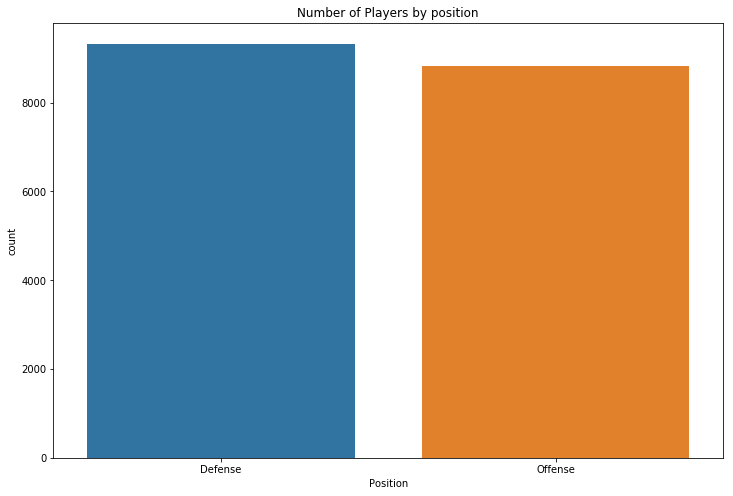

In [12]:
# Count number of players in each position using countplot
plt.figure(figsize=(12, 8))
plt.title("Number of Players by position")
fig = sns.countplot(x = 'Position', data =df)

In [13]:
df.head()

,Age,Preferred Foot,Position,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,31,0,Defense,188.0,181,13,10,10,50,11,...,14,31,27,10,30,40,65,29,10,18
1,28,1,Defense,188.0,181,14,11,16,30,11,...,13,32,21,10,41,22,52,15,18,14
2,29,1,Defense,198.0,216,14,11,15,25,11,...,9,36,23,11,42,21,61,10,12,10
3,22,0,Offense,180.0,161,65,75,64,77,75,...,66,60,45,79,74,69,73,38,40,37
4,20,1,Offense,185.0,168,68,69,44,69,68,...,66,53,17,71,69,58,75,25,16,21


In [14]:
# Divide the data to train and test

# Drop the elements that has been created for 
# drop_elements = ['Finishing_cat', 'Strength_cat', 'FKAccuracy_cat']
# df=df.drop(drop_elements, axis = 1)

# Create the unique values for the positions encoded as Defemse:0, Offense:2
positions = df["Position"].unique()
encoder = preprocessing.LabelEncoder()
df['Position'] = encoder.fit_transform(df['Position'])

#The Y feature is the position
y = df["Position"]

#The other features are all but the position
df.drop(columns=["Position"],inplace=True)

#Split the data
X_train_dev, X_test, y_train_dev, y_test = train_test_split(df, y, 
                                                    test_size=0.20, 
                                                    random_state=42 )

In [15]:
# Plot the confusion matrix
def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    sns.set(font_scale=1.4)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [17]:
def plot_curve(ticks, train_scores, test_scores):
    train_scores_mean = -1 * np.mean(train_scores, axis=1)
    train_scores_std = -1 * np.std(train_scores, axis=1)
    test_scores_mean = -1 * np.mean(test_scores, axis=1)
    test_scores_std = -1 * np.std(test_scores, axis=1)

    plt.figure()
    plt.fill_between(ticks, 
                     train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(ticks, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color="r")
    plt.plot(ticks, train_scores_mean, 'b-', label='Training Error')
    plt.plot(ticks, test_scores_mean, 'r-', label='Validation Error')
    plt.legend(fancybox=True, facecolor='w')

    return plt.gca()

def plot_validation_curve(clf, X, y, param_name, param_range, scoring='accuracy'):
    plt.xkcd()
    ax = plot_curve(param_range, *validation_curve(clf, X, y, cv=4, 
                                                   scoring=scoring, 
                                                   param_name=param_name, 
                                                   param_range=param_range, n_jobs=4))
    ax.set_title('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(2,12)
    ax.set_ylim(-0.97, -0.83)
    ax.set_ylabel('Error')
    ax.set_xlabel('Model complexity')
    ax.text(9, -0.94, 'Overfitting', fontsize=14)
    ax.text(3, -0.94, 'Underfitting', fontsize=14)
    ax.axvline(7, ls='--')
    plt.tight_layout()

In [18]:
def train_and_score(clf,X_train,y_train,X_test,y_test):
    clf = clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    cf = confusion_matrix(y_test,preds)

    print(plot_confusion_matrix(cf, class_names=positions))

    print(" Accuracy: ",accuracy_score(y_test, preds))
    print(" F1 score: ",metrics.f1_score(y_test, preds,average='weighted'))

Figure(720x504)
 Accuracy:  0.9316804407713498
 F1 score:  0.9316515423078637


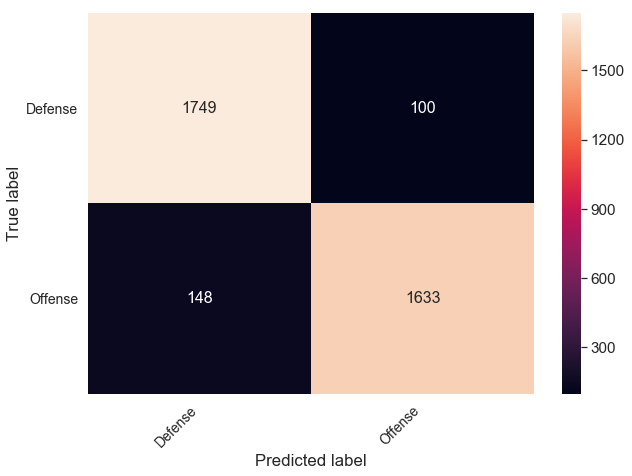

In [19]:
LR = LogisticRegressionCV(cv=5,random_state=20, solver='lbfgs',
                             multi_class='multinomial')
train_and_score(LR,X_train_dev,y_train_dev,X_test,y_test)

<module 'matplotlib.pyplot' from 'C:\\Users\\ericl\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

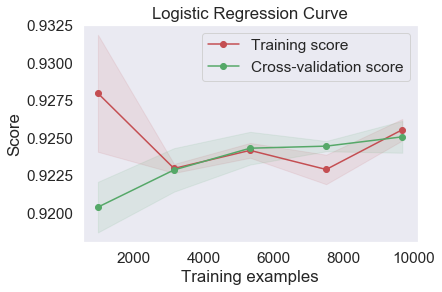

In [20]:
plot_learning_curve(LR, "Logistic Regression Curve", X_train_dev, y_train_dev)

In [ ]:
#create new a knn model
knn_model = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
KNN = GridSearchCV(knn_model, param_grid, cv=5)

train_and_score(KNN,X_train_dev,y_train_dev,X_test,y_test)

In [ ]:
plot_learning_curve(KNN, "KNN Regression Curve", X_train_dev, y_train_dev)